Affine coordinate space has parrallel lines eg. cartesian coordinate space

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
from scipy.ndimage import measurements
import matplotlib.cm as cm
from pcaRotate import *
import sys
sys.path.append("../py/")
from fitEllipse import fitEllipse

Image moments by $$M_{ij} = \Sigma_x \Sigma_y x^{i} y^{j} f(x,y)$$
Centroid $$\bar{x} = M_{10}/M_{00}, \bar{y} = M_{01}/M_{00}$$

Central moments = $$ \Sigma_x \Sigma_y (x-\bar{x})^{i} (y-\bar{y})^{j} f(x,y) $$

In [11]:
imgPaths = glob.glob("/home/msmith/kaggle/whale/imgs/test/m1_6869.jpg")

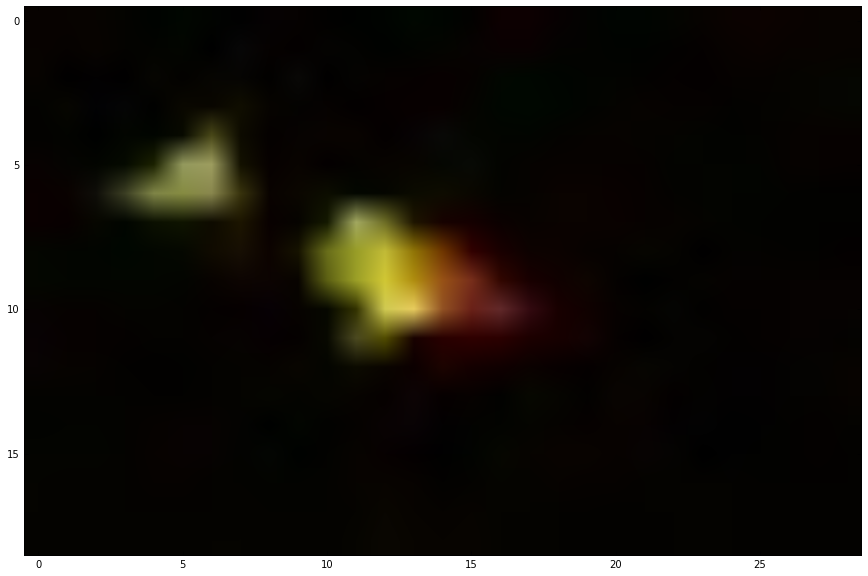

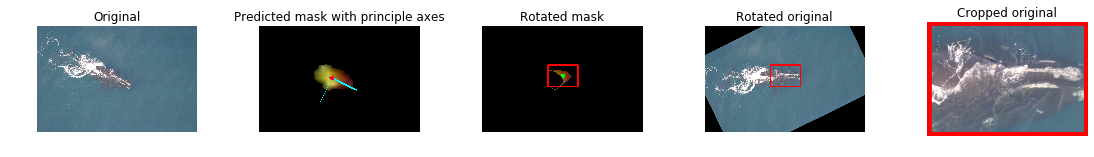

In [12]:
def example_plot(ax, img, name,fontsize=12):
    ax.imshow(img)
    ax.locator_params(nbins=3)
    ax.set_title(name, fontsize=fontsize)
    ax.axis('off')

def show(im):
    plt.imshow(im)
    plt.show()
name = 0
for i in range(len(imgPaths)):
    
    imPath = imgPaths[i]
    
    orig = cv2.imread(imPath.replace("m1_","w1_"))[:,:,::-1]
    mask = cv2.imread(imPath.replace("m1_","m1_"))[:,:,::-1]
    maskOrig = mask.copy()
    
    plt.imshow(mask)
    plt.show()
    h,w,c = orig.shape
    mask = cv2.resize(mask,(w,h),interpolation=cv2.INTER_LINEAR)
    h,w,c = mask.shape
    channel = 0 #Red
    
    # Call fns
    mask = getRedYellow(mask,(50,50,200))
    mask = fitEllipse(mask,10,250)
    centroidR, covR = getImgMoments(mask,0)
    centroidG, covG = getImgMoments(mask,1)
    e1,e2 = evs = getEigenVectors(centroid1=centroidG,centroid2=centroidR,cov=covR)
    
    rotOrig = orig.copy()
    rotMask = mask.copy()
    rotOrig, rotMask = rotate(rotOrig,rotMask,evs,centroidR)
    rotMask = getRed(rotMask,(100,100,200))

    im = rotMask[:,:,0]
    ret,im = cv2.threshold(im,5,255,0)
    contours, _ = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contourAreas = [cv2.contourArea(x) for x in contours]
    argMaxContourAreas = contourAreas.index(max(contourAreas))

    rect = cv2.boundingRect(contours[argMaxContourAreas])
    x,y,w,h = rect
    
    # Keep aspect ratio the same - do not want to stretch whales
    ar = 16/9.0
    w = int(h*ar)
    
    centroidRotRed, _ = getImgMoments(rotMask,0) #Redo centroid to crop head 
    w = np.array([280,200])
    topLeft = centroidRotRed - w
    bottomRight = centroidRotRed + w
    croppedHead = rotOrig[topLeft[1]:bottomRight[1],topLeft[0]:bottomRight[0]]
    cv2.rectangle(rotMask,(topLeft[0],topLeft[1]),(bottomRight[0],bottomRight[1]),(255,0,0),30)
    cv2.rectangle(rotOrig,(topLeft[0],topLeft[1]),(bottomRight[0],bottomRight[1]),(255,0,0),30)
    #croppedHead = rotOrig[y:y+h,x:x+w]

    # For display 
    arroLen = 500
    arrowToE1 = tuple((centroidR + (e1)*arroLen).astype(np.uint16))
    arrowToE2 = tuple((centroidR + (e2)*arroLen).astype(np.uint16))
    centroidRT = totuple(centroidR)
    centroidGT = totuple(centroidG)
    centroidRotRedT = totuple(centroidRotRed)
    
    dis = mask.copy()
    cv2.line(dis,centroidRT,arrowToE1,(0,255,255),30)
    cv2.line(dis,centroidRT,arrowToE2,(0,255,255),10)
    cv2.line(dis,centroidGT,centroidRT,(0,0,255),30)
    cv2.circle(dis,centroidRT,40,(255,0,50),-1,lineType=8)
    cv2.circle(rotMask,centroidRotRedT,40,(0,255,0),-1)
    
    #plt.title(imPath)
    plt.close('all')
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5)
    fs = 12
    example_plot(ax1, orig, name = "Original", fontsize=fs)
    example_plot(ax2, dis, name = "Predicted mask with principle axes",fontsize=fs)
    example_plot(ax3, rotMask, name = "Rotated mask",fontsize=fs)
    example_plot(ax4, rotOrig, name = "Rotated original",fontsize=fs)
    example_plot(ax5, croppedHead, name = "Cropped original",fontsize=fs)
    plt.tight_layout(pad=0.01, w_pad=0.01, h_pad=0.01)
    plt.savefig("example_"+str(name)+".png", bbox_inches='tight')
    plt.show()
    name += 1

